## Test the use of a pre-trained transformer model for text classification

### Load libraries

In [97]:
# Data wrangling
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from pyprojroot.here import here

# Model training
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm
from datasets import load_metric

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess data

In [47]:
# Load the training data and combine
data_path = here("data/training_data")
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".csv")]
df_list = [pd.read_csv(file) for file in all_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Load the excel file containing category information
category_info = pd.read_excel(here("data/All_Updated_Categories_2019_edited_by_mikkel.xlsx"))

# Merge the dataframes
merged_df = pd.merge(
  combined_df, 
  category_info, 
  left_on = "SubType", 
  right_on = "subcategory",
  how = "left"
)

### Quality control

In [48]:
# Check the number of documents for each class, category, and subcategory
class_counts = merged_df['class'].value_counts()
subcategory_counts = merged_df['subcategory'].value_counts()

print("Class Counts:\n", class_counts)
print("\nSubcategory Counts:\n", subcategory_counts)

Class Counts:
 class
Infectious_Disease    27508
Other                 11514
Autoimm               11167
Cancer                10957
Allergen               4019
Transplant             1805
Name: count, dtype: int64

Subcategory Counts:
 subcategory
OTC       2885
OTFLU     2534
OTGA      2479
PLASMO    2183
SARS      2175
          ... 
FIB         23
METAL       23
BIME        20
INTG        17
PROST       16
Name: count, Length: 176, dtype: int64


In [49]:
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               8
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [50]:
# Look at the papers with missing titles
merged_df[merged_df.Title.isnull()]

,PubMed_ID,Title,Abstract,SubType,Class,Category,Subcategory,Abbreviation,OK,class,category,subcategory
5459,11006009,NaN,[Data extracted from this article was imported...,HCV,Infectious Disease,ssRNA (+) Strand Virus,Hepatitis C Virus,HCV,x,Infectious_Disease,ssRNA_positive,HCV
10499,8567982,NaN,[Data extracted from this article was imported...,HBV,Infectious Disease,Retro-Transcribing Virus,Hepatitis B Virus,HBV,x,Infectious_Disease,Retro-Transcribing_Virus,HBV
13215,11012976,NaN,[Data extracted from this article was imported...,OTFLU,Infectious Disease,ssRNA (-) Strand Virus,Other Influenza A Subtypes,OTFLU,x,Infectious_Disease,ssRNA_negative,OTFLU
16750,11426965,NaN,[Data extracted from this article was imported...,HPV,Infectious Disease,dsDNA Virus,Human papillomavirus,HPV,x,Infectious_Disease,dsDNA_Virus,HPV
24876,15585860,NaN,Structural and physiological facets of carbohy...,MOAB,Other,Peptidic Antigen,General Monoclonal Antibodies,MOAB,x,Other,Peptidic_Antigen,MOAB
44549,15001714,NaN,CD8 T lymphocytes recognize peptides of 8 to 1...,MAA,Cancer,NaN,"Tyrosinase, TRP2, GP100, TRP1, MART1, SOX10 (M...",MAA,x,Cancer,NaN,MAA
54471,29572442,NaN,The B cell survival factor (TNFSF13B/BAFF) is ...,OTLUP,Autoimmune,Lupus,Other,OTLUP,x,Autoimm,Lupus,OTLUP
63300,14724640,NaN,Cytotoxic T lymphocytes (CTLs) detect and dest...,RENAL,Cancer,NaN,Renal (RCC),RENAL,x,Cancer,NaN,RENAL


It seems like there are some of the abstract there are not extracted correctly.
They all starts with "[Data extracted from this article was imported...".

In [51]:
# Create a boolean mask for rows where the abstract starts with the specified string
mask = merged_df['Abstract'].str.startswith("[Data extracted from this article was imported")

# Filter out these rows
filtered_df = merged_df[~mask]

# Check the number of rows before and after filtering
print(f"Number of rows before filtering: {len(merged_df)}")
print(f"Number of rows after filtering: {len(filtered_df)}")
print(f"Difference: {len(merged_df) - len(filtered_df)}")


Number of rows before filtering: 67457
Number of rows after filtering: 67403
Difference: 54


In [52]:
missing_values = filtered_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               4
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [53]:
### Split the Data for the class variable

# Drop rows where 'class' is NA
filtered_df = filtered_df.dropna(subset=['class'])

# Check the number of rows after dropping
print(f"Number of rows after dropping NAs in 'class': {len(filtered_df)}")

# Split the data into train and a temporary dataset (70% train, 30% temp)
train_df, temp_df = train_test_split(filtered_df, test_size=0.3, random_state=42, stratify=filtered_df['class'])

# Split the temporary dataset into validation and test datasets (50% validation, 50% test from the temp dataset)
eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['class'])

# Initialize the label encoder
label_encoder = LabelEncoder()

# Transform class label from string to integers
# Fit the encoder on the 'class' column and transform it
train_df['class_int'] = label_encoder.fit_transform(train_df['class'])
eval_df['class_int'] = label_encoder.transform(eval_df['class'])
test_df['class_int'] = label_encoder.transform(test_df['class'])


# Check the number of rows in each dataset
print(f"Number of rows in train dataset: {len(train_df)}")
print(f"Number of rows in validation dataset: {len(eval_df)}")
print(f"Number of rows in test dataset: {len(test_df)}")

Number of rows after dropping NAs in 'class': 66916
Number of rows in train dataset: 46841
Number of rows in validation dataset: 10037
Number of rows in test dataset: 10038


In [54]:
# Check the number of documents from each class in the train dataset
train_class_counts = train_df['class'].value_counts()

# Check the number of documents from each class in the validation dataset
valid_class_counts = eval_df['class'].value_counts()

# Check the number of documents from each class in the test dataset
test_class_counts = test_df['class'].value_counts()

print("Number of documents from each class in train dataset:\n", train_class_counts)
print("\nNumber of documents from each class in validation dataset:\n", valid_class_counts)
print("\nNumber of documents from each class in test dataset:\n", test_class_counts)

Number of documents from each class in train dataset:
 class
Infectious_Disease    19219
Other                  8058
Autoimm                7817
Cancer                 7670
Allergen               2813
Transplant             1264
Name: count, dtype: int64

Number of documents from each class in validation dataset:
 class
Infectious_Disease    4118
Other                 1727
Autoimm               1675
Cancer                1643
Allergen               603
Transplant             271
Name: count, dtype: int64

Number of documents from each class in test dataset:
 class
Infectious_Disease    4119
Other                 1727
Autoimm               1675
Cancer                1644
Allergen               603
Transplant             270
Name: count, dtype: int64


### Fine-tune the BioBert transformer model

In [91]:
# Load BioBERT and tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(train_df['class_int'].unique())
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 1. Tokenization
data_size = 1000
train_abstract = train_df['Abstract'].tolist()[1:data_size]
eval_abstract = eval_df['Abstract'].tolist()[1:data_size]
tokenized_train = tokenizer(train_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)
tokenized_eval = tokenizer(eval_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Convert tokenized data to PyTorch dataset
train_labels = train_df['class_int'].tolist()[1:data_size]
eval_labels = eval_df["class_int"].tolist()[1:data_size]
train_dataset = CustomDataset(encodings = tokenized_train, labels = train_labels)
eval_dataset = CustomDataset(encodings = tokenized_eval, labels = eval_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)


In [93]:
# 2. Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()

# For accumulating loss over the epoch
total_loss = 0.0

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Add the batch loss to the total loss
        total_loss += loss.item()

        progress_bar.update(1)
        
        # Print loss for the current batch
        print(f"Batch Loss: {loss.item():.4f}")
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    
    # Reset total_loss for the next epoch
    total_loss = 0.0


100%|██████████| 13/13 [04:18<00:00, 19.87s/it]

Batch Loss: 1.8025


Batch Loss: 1.6198


Batch Loss: 1.7800


Batch Loss: 1.8826


Batch Loss: 1.5169


Batch Loss: 1.7098


Batch Loss: 1.5240


Batch Loss: 1.9087


Batch Loss: 1.2770


Batch Loss: 1.4271


Batch Loss: 1.3241


Batch Loss: 1.6042


Batch Loss: 1.8211


Batch Loss: 1.9212


Batch Loss: 1.5208


Batch Loss: 1.6284


Batch Loss: 1.9323


Batch Loss: 1.7690


Batch Loss: 1.7271


Batch Loss: 1.6395


Batch Loss: 1.4264


Batch Loss: 1.4978


Batch Loss: 1.6013


Batch Loss: 1.4709


Batch Loss: 1.9441


Batch Loss: 1.5080


Batch Loss: 1.6590


Batch Loss: 1.6869


Batch Loss: 1.6643


Batch Loss: 1.5859


Batch Loss: 1.5191


Batch Loss: 1.6378


Batch Loss: 1.4023


Batch Loss: 1.3319


Batch Loss: 1.6366


Batch Loss: 1.2039


Batch Loss: 1.1213


Batch Loss: 1.3609


Batch Loss: 1.0982


Batch Loss: 1.3717


Batch Loss: 1.2572


Batch Loss: 1.0563


Batch Loss: 0.9384


Batch Loss: 1.0976


Batch Loss: 1.4439


Batch Loss: 1.1710


Batch Loss: 1.5721


Batch Loss: 0.9654


Batch Loss: 0.3700


Batch Loss: 1.0918


Batch Loss: 0.7608


Batch Loss: 0.7069


Batch Loss: 1.3792


Batch Loss: 1.3709


Batch Loss: 0.6865


Batch Loss: 0.8511


Batch Loss: 1.4514


Batch Loss: 1.0435


Batch Loss: 0.8073


Batch Loss: 0.9681


Batch Loss: 0.7656


Batch Loss: 0.7732


Batch Loss: 0.7830


Batch Loss: 1.1044


Batch Loss: 0.8061


Batch Loss: 1.1636


Batch Loss: 0.5533


Batch Loss: 0.8314


Batch Loss: 0.8845


Batch Loss: 1.0275


Batch Loss: 1.2705


Batch Loss: 1.3937


Batch Loss: 0.2000


Batch Loss: 0.6081


Batch Loss: 0.6458


Batch Loss: 0.4323


Batch Loss: 0.5700


Batch Loss: 1.0620


Batch Loss: 1.0395


Batch Loss: 0.9980


Batch Loss: 0.8449


Batch Loss: 0.7913


Batch Loss: 1.0866


Batch Loss: 0.9577


Batch Loss: 0.3770


Batch Loss: 0.9629


Batch Loss: 0.3714


Batch Loss: 1.0394


Batch Loss: 0.7832


Batch Loss: 0.6756


Batch Loss: 0.7626


Batch Loss: 0.9987


Batch Loss: 0.3057


Batch Loss: 0.8720


Batch Loss: 0.3786


Batch Loss: 0.5854


Batch Loss: 0.7916


Batch Loss: 0.8193


Batch Loss: 0.9556


Batch Loss: 0.9318


Batch Loss: 0.5421


Batch Loss: 0.5771


Batch Loss: 0.6886


Batch Loss: 0.7594


Batch Loss: 0.7681


Batch Loss: 0.5066


Batch Loss: 1.0082


Batch Loss: 0.6104


Batch Loss: 1.3908


Batch Loss: 0.6277


Batch Loss: 0.5534


Batch Loss: 0.3152


Batch Loss: 0.3139


Batch Loss: 0.5068


Batch Loss: 0.8839


Batch Loss: 1.6826


Batch Loss: 0.3303


Batch Loss: 0.5813


Batch Loss: 0.3893


Batch Loss: 0.6701


Batch Loss: 0.5684


Batch Loss: 0.5516


Batch Loss: 0.3169


Batch Loss: 0.6561


Batch Loss: 0.6540
Epoch 1 Average Loss: 1.0617


In [106]:
# 3. Evaluation
metric = load_metric("accuracy")

# Store probabilities, predictions and true labels
all_scores = []
all_predictions = []
all_true_labels = []

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits

    # Get probabilities and predictions
    scores = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # For computing the metric
    metric.add_batch(predictions=predictions, references=batch["labels"])

    # Save probabilites, predictions and labels
    all_scores.extend(scores)
    all_predictions.extend(predictions)
    all_true_labels.extend(batch["labels"].cpu().numpy())

print(metric.compute())

{'accuracy': 0.8388388388388388}


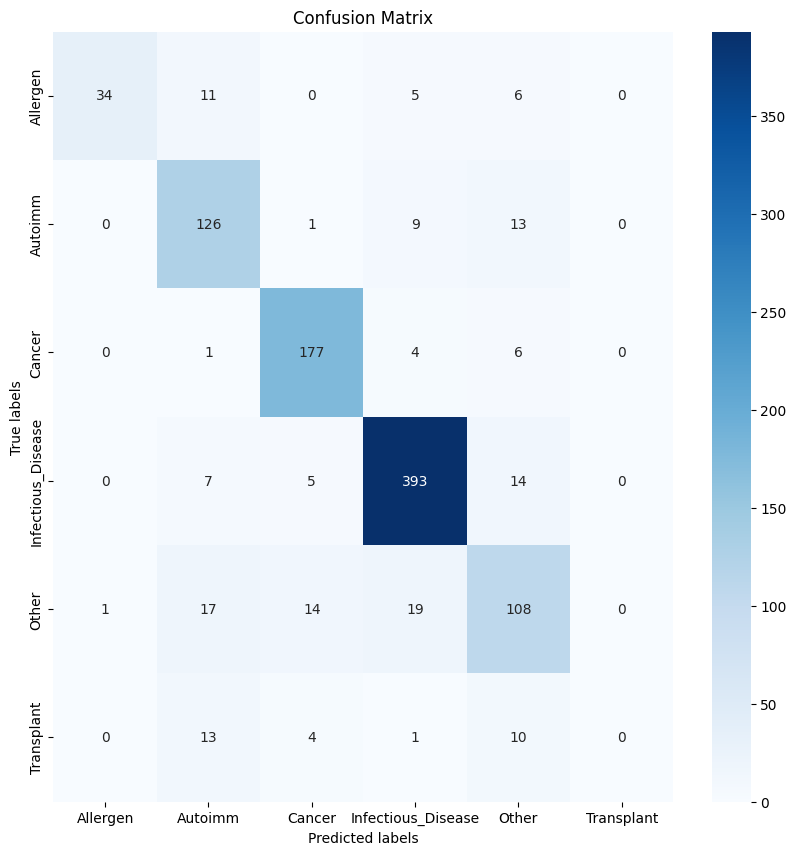

In [122]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [123]:
print(classification_report(all_true_labels, all_predictions, target_names=label_encoder.classes_))

                    precision    recall  f1-score   support

          Allergen       0.97      0.61      0.75        56
           Autoimm       0.72      0.85      0.78       149
            Cancer       0.88      0.94      0.91       188
Infectious_Disease       0.91      0.94      0.92       419
             Other       0.69      0.68      0.68       159
        Transplant       0.00      0.00      0.00        28

          accuracy                           0.84       999
         macro avg       0.70      0.67      0.67       999
      weighted avg       0.82      0.84      0.83       999



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

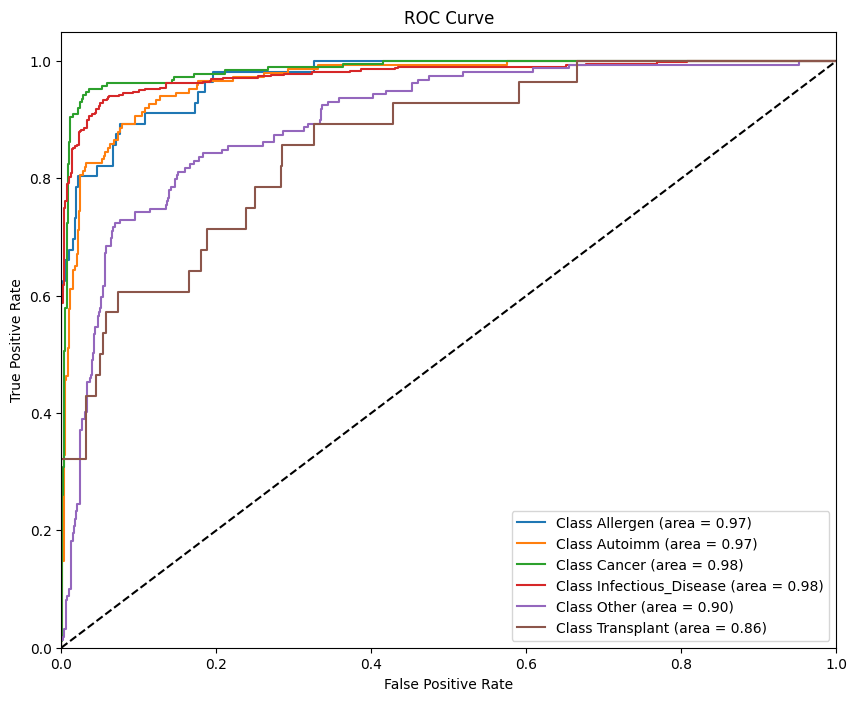

In [109]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



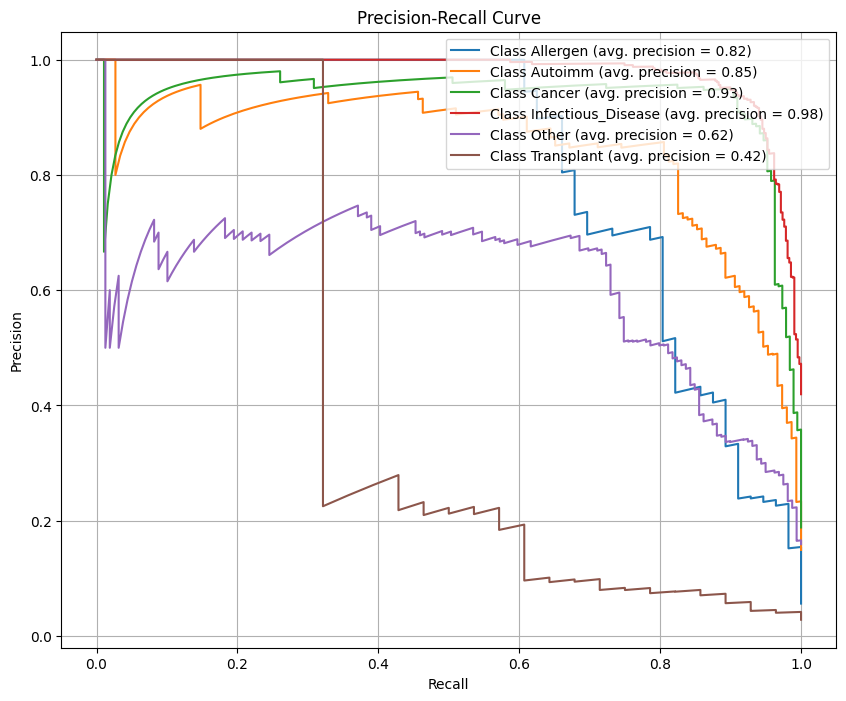

In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# Compute Precision-Recall and plot curve for each class
for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (avg. precision = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [114]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_aucs = []
pr_aucs = []

# Binarize the labels for multi-class AUC calculation
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

# Calculate AUC for each class
for i in range(len(label_encoder.classes_)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    pr_auc = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)


# Create a DataFrame
df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs
})

# Display the table
print(df)


                Class   ROC AUC    PR AUC
0            Allergen  0.970705  0.824171
1             Autoimm  0.967209  0.848195
2              Cancer  0.984751  0.932776
3  Infectious_Disease  0.977541  0.976640
4               Other  0.898899  0.615896
5          Transplant  0.857989  0.418492


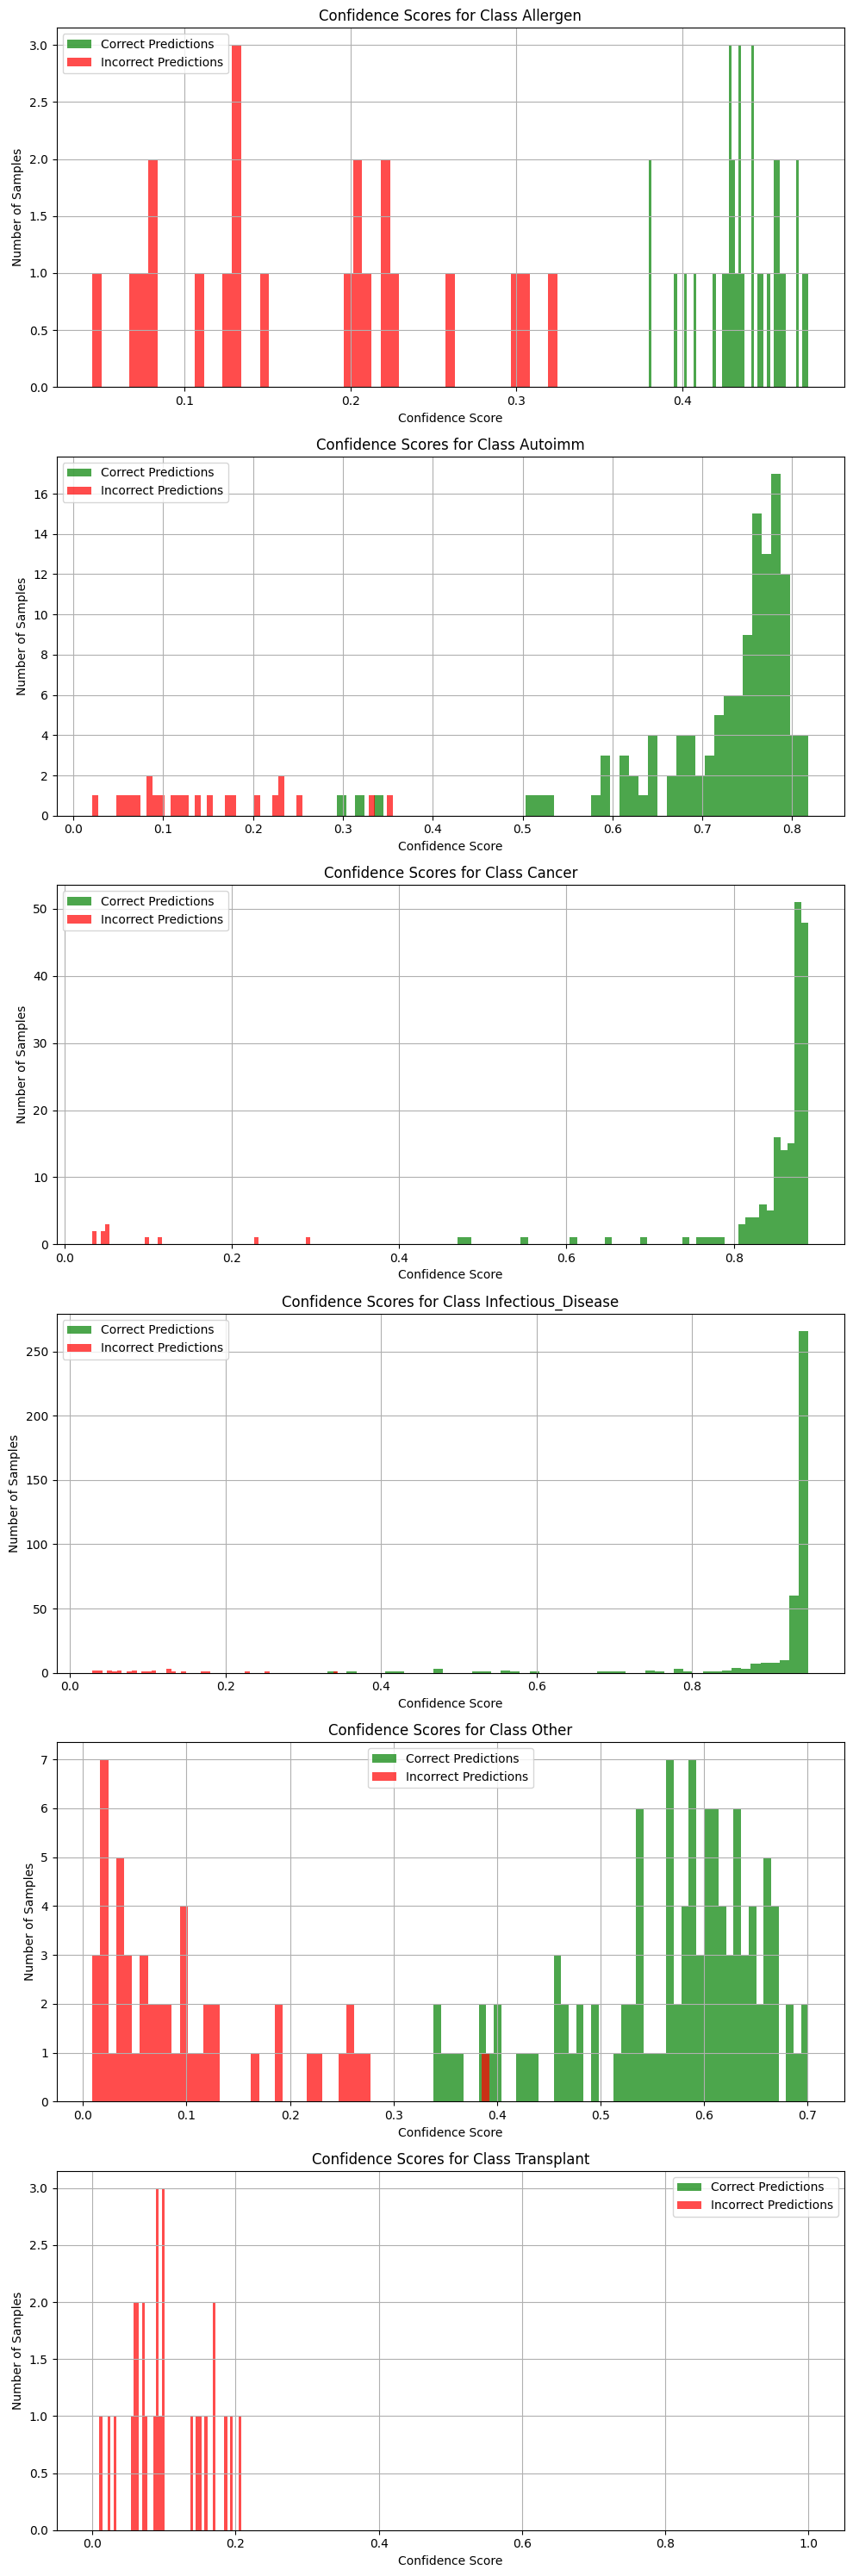

In [173]:
# Convert predictions and true labels to a numpy array for easier indexing
predicted_classes = np.array(all_predictions)
true_classes = np.array(all_true_labels)

# Number of classes
num_classes = len(label_encoder.classes_)

# Plot histograms for confidence scores of each class separately
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 5 * num_classes))

for i in range(num_classes):
    # Correct predictions for this class
    correct_mask = (predicted_classes == i) & (true_classes == i)
    incorrect_mask = (predicted_classes != i) & (true_classes == i)
    
    axes[i].hist(all_scores_np[correct_mask, i], bins=50, color='green', alpha=0.7, label='Correct Predictions')
    axes[i].hist(all_scores_np[incorrect_mask, i], bins=50, color='red', alpha=0.7, label='Incorrect Predictions')
    
    axes[i].set_title(f'Confidence Scores for Class {label_encoder.classes_[i]}')
    axes[i].set_xlabel('Confidence Score')
    axes[i].set_ylabel('Number of Samples')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
